In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
# For modeling
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from tqdm import tqdm
from matplotlib.colors import ListedColormap
#sns.set_palette('viridis')
pd.options.mode.chained_assignment = None  # Supress warning, default='warn'

# Read Data
In this section we read the data in after the preprocessing from the preprocessing notebook

In [2]:
df = pd.read_pickle('../data/preprocessed/accepted_df_preprocessed.pkl')
print(f"Shape of df: {df.shape}")
df.head(5)

Shape of df: (1345310, 101)


,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
0,3600.0,3600.0,3600.0,36,13.99,123.03,C,C4,10.0,MORTGAGE,...,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,N,Cash,N
1,24700.0,24700.0,24700.0,36,11.99,820.28,C,C1,10.0,MORTGAGE,...,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,N,Cash,N
2,20000.0,20000.0,20000.0,60,10.78,432.66,B,B4,10.0,MORTGAGE,...,50.0,0.0,0.0,218418.0,18696.0,6200.0,14877.0,N,Cash,N
4,10400.0,10400.0,10400.0,60,22.45,289.91,F,F1,3.0,MORTGAGE,...,60.0,0.0,0.0,439570.0,95768.0,20300.0,88097.0,N,Cash,N
5,11950.0,11950.0,11950.0,36,13.44,405.18,C,C3,4.0,RENT,...,100.0,0.0,0.0,16900.0,12798.0,9400.0,4000.0,N,Cash,N


# TAKE SUBSAMPLE OF DATA FOR COMPUTATION ISSUES (TODO: DELETE THIS LATER)

In [3]:
df = df.sample(frac = 0.1)
print(df.shape)

(134531, 101)


# Model Preprocessing: Encode Features from categorical to numerical

In [4]:
# Preview categorical data
print(df.dtypes.value_counts())
# Get categorical columns names
cat_columns = df.select_dtypes(include=['object']).columns.tolist()
# Preview
print(cat_columns)

float64    87
object     13
int64       1
dtype: int64
['term', 'grade', 'sub_grade', 'home_ownership', 'verification_status', 'pymnt_plan', 'purpose', 'addr_state', 'initial_list_status', 'application_type', 'hardship_flag', 'disbursement_method', 'debt_settlement_flag']


### Deleted irrelevant categorical features
Delete categorical features that are not relevant for the Modelling or contain too many realization so that encoding them would be infeasible.

In [5]:
# Keep: disbursement_method, home_ownership, pymnt_plan
CAT_COLS_TO_KEEP = ["disbursement_method", "home_ownership", "pymnt_plan"]
CAT_COLS_TO_DROP = [col for col in cat_columns if col not in CAT_COLS_TO_KEEP]

print(f"Categorical Columns to drop: {CAT_COLS_TO_DROP}\n")
print(f"Shape of df before columns drop: {df.shape}")
# Drop irrelevant categorical features
df.drop(CAT_COLS_TO_DROP, axis=1, inplace=True)
print(f"Shape of df after columns drop: {df.shape}")

Categorical Columns to drop: ['term', 'grade', 'sub_grade', 'verification_status', 'purpose', 'addr_state', 'initial_list_status', 'application_type', 'hardship_flag', 'debt_settlement_flag']

Shape of df before columns drop: (134531, 101)
Shape of df after columns drop: (134531, 91)


In [6]:
print(df.dtypes.value_counts())

float64    87
object      3
int64       1
dtype: int64


In [7]:
# Testing: One-Hot-Encoding
#df_ohe = pd.get_dummies(data=df, columns=cat_columns, drop_first=True)
# check
#df_ohe.dtypes.value_counts()

In [8]:
# Binary Encoding
import category_encoders as ce
encoder = ce.BinaryEncoder(cols=CAT_COLS_TO_KEEP)
df_binary = encoder.fit_transform(df)
# check
df_binary.dtypes.value_counts()

float64    87
int64       7
dtype: int64

In [9]:
# Convert all values to float
df_binary = df_binary.astype(float)
df_binary.dtypes.value_counts()
#df_ohe = df_ohe.astype(float)

float64    94
dtype: int64

## Preview preprocessed dataframe:

In [10]:
df_binary.head(10)

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,emp_length,home_ownership_0,home_ownership_1,home_ownership_2,annual_inc,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,disbursement_method_0,disbursement_method_1
1032488,16800.0,16800.0,16800.0,5.32,505.93,10.0,0.0,0.0,1.0,82000.0,...,96.0,0.0,0.0,0.0,136210.0,27753.0,13000.0,17110.0,0.0,1.0
1541118,20000.0,20000.0,20000.0,12.13,665.53,10.0,0.0,0.0,1.0,83000.0,...,83.8,100.0,0.0,0.0,182740.0,40474.0,3500.0,39640.0,0.0,1.0
932183,4000.0,4000.0,4000.0,7.21,123.90,10.0,0.0,0.0,1.0,48000.0,...,90.9,50.0,0.0,0.0,110051.0,23366.0,15700.0,29047.0,0.0,1.0
1046561,21000.0,21000.0,21000.0,9.16,437.56,3.0,0.0,0.0,1.0,125000.0,...,100.0,20.0,0.0,0.0,351296.0,159530.0,53100.0,127304.0,0.0,1.0
114521,5075.0,5075.0,5075.0,16.99,180.92,0.0,0.0,1.0,0.0,17000.0,...,50.0,0.0,0.0,0.0,3800.0,333.0,1100.0,0.0,0.0,1.0
1240026,28000.0,28000.0,28000.0,15.61,675.12,0.0,0.0,0.0,1.0,195000.0,...,94.3,80.0,0.0,0.0,740629.0,128437.0,38000.0,157829.0,0.0,1.0
746465,6500.0,6500.0,6500.0,5.32,195.75,0.0,0.0,0.0,1.0,57000.0,...,100.0,0.0,0.0,0.0,475277.0,7771.0,27000.0,24777.0,0.0,1.0
1954123,20000.0,20000.0,20000.0,17.99,722.95,3.0,0.0,1.0,0.0,80000.0,...,85.7,100.0,0.0,0.0,29775.0,25363.0,500.0,25575.0,0.0,1.0
99492,22500.0,22500.0,22500.0,6.89,693.61,2.0,0.0,0.0,1.0,108000.0,...,100.0,50.0,0.0,0.0,134000.0,87527.0,56900.0,18000.0,0.0,1.0
1709503,8000.0,8000.0,8000.0,11.49,263.78,10.0,0.0,1.0,1.0,65000.0,...,92.0,75.0,0.0,0.0,25813.0,11856.0,16000.0,4013.0,0.0,1.0


# Create Balanced Data Set via Downsampling

0.0    107691
1.0     26840
Name: loan_status, dtype: int64
(134531, 94)


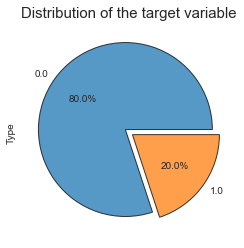

In [11]:
print(df_binary.loan_status.value_counts())
print(df_binary.shape)

plt.title("Distribution of the target variable", size=15)
df_binary.groupby('loan_status').size().plot(kind='pie', y = "loan_status",
                                             label = "Type", autopct='%1.1f%%',
                                             wedgeprops = {"edgecolor": "black", "alpha": 0.75},
                                             explode = [0.05, 0.05])
plt.show()

0.0    34892
1.0    26840
Name: loan_status, dtype: int64


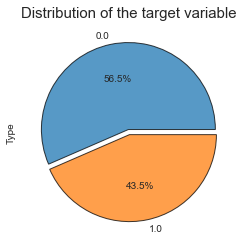

In [12]:
# Downsampling
loan_status_0 = df_binary[df_binary["loan_status"] == 0.0]
loan_status_1  = df_binary[df_binary["loan_status"] == 1.0]

loan_status_0_downsample = resample(loan_status_0,
             replace=True,
             n_samples=round(1.3*len(loan_status_1)),
             random_state=42)

df_binary_downsampled = pd.concat([loan_status_0_downsample, loan_status_1])

print(df_binary_downsampled["loan_status"].value_counts())
# Plot settings
plt.title("Distribution of the target variable", size=15)
df_binary_downsampled.groupby('loan_status').size().plot(kind='pie', y = "loan_status",
                                             label = "Type", autopct='%1.1f%%',
                                             wedgeprops = {"edgecolor": "black", "alpha": 0.75},
                                             explode = [0.03, 0.03])
plt.show()

# Data Imputation

In [13]:
# Fill NaNs with Median
df_binary_downsampled = df_binary_downsampled.fillna(df_binary_downsampled.median())
# Preview
df_binary_downsampled.head(5)

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,emp_length,home_ownership_0,home_ownership_1,home_ownership_2,annual_inc,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,disbursement_method_0,disbursement_method_1
1295675,2875.0,2875.0,2875.0,15.61,100.53,6.0,0.0,1.0,0.0,85000.0,...,100.0,36.4,0.0,0.0,61500.0,30144.0,48400.0,0.0,0.0,1.0
1937183,14000.0,14000.0,14000.0,9.91,451.15,4.0,0.0,0.0,1.0,67500.0,...,97.8,50.0,0.0,0.0,104198.0,37681.0,14500.0,31847.0,0.0,1.0
109520,35000.0,35000.0,35000.0,7.89,1095.00,0.0,0.0,0.0,1.0,95000.0,...,96.0,35.7,0.0,0.0,278230.0,67578.0,112900.0,18899.0,0.0,1.0
1618743,4200.0,4200.0,4200.0,12.69,140.89,2.0,0.0,0.0,1.0,120000.0,...,97.8,50.0,0.0,0.0,104198.0,37681.0,14500.0,31847.0,0.0,1.0
222213,27000.0,27000.0,27000.0,12.69,610.06,2.0,0.0,1.0,0.0,82300.0,...,89.5,66.7,0.0,0.0,30100.0,20193.0,29500.0,0.0,0.0,1.0


# Data Split
In this section we split the data into a training and test set. The corresponding model is then trained on the training set and tested on the test set.

In [14]:
# Fraction of test data
TEST_SIZE = 0.3

X = df_binary_downsampled.drop("loan_status", axis=1)
y = df_binary_downsampled["loan_status"]

# Split data into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=42, stratify=y)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (43212, 93)
Shape of X_test: (18520, 93)
Shape of y_train: (43212,)
Shape of y_test: (18520,)


# Scaling
We scale the data with the MinMaxScaler to a range of $[0, 1]$

In [15]:
# Init object
scaler = MinMaxScaler()
# Scale X_train
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled)
# Scale X_test
X_test_scaled = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled)

# Preview X_train_scaled
X_train_scaled.head(5)

,0,1,2,3,4,5,6,7,8,9,...,83,84,85,86,87,88,89,90,91,92
0,0.025641,0.025641,0.05,0.287383,0.025838,0.4,0.0,0.0,1.0,0.006083,...,1.000000,1.000,0.0,0.0,0.012384,0.020963,0.009618,0.019539,0.0,1.0
1,0.230769,0.230769,0.25,0.079050,0.113112,0.5,0.0,0.0,1.0,0.011630,...,0.939759,0.000,0.0,0.0,0.042379,0.021571,0.077494,0.023953,0.0,1.0
2,0.487179,0.487179,0.50,0.079439,0.390407,1.0,0.0,1.0,0.0,0.015924,...,1.000000,0.125,0.0,0.0,0.009130,0.008725,0.149766,0.000000,0.0,1.0
3,0.487179,0.487179,0.50,0.240265,0.415811,0.0,0.0,1.0,0.0,0.011230,...,1.000000,1.000,0.0,0.0,0.008064,0.030302,0.046716,0.039076,0.0,1.0
4,0.128205,0.128205,0.15,0.238707,0.111835,0.3,0.0,1.0,0.0,0.008946,...,1.000000,0.000,0.0,0.0,0.005696,0.010184,0.059907,0.021122,0.0,1.0


---
# Task 3: Logistic Regression In Sample
Use logistic regression (in-sample) for default prediction. Interpret your results for logistic regression

In [16]:
# Fit Model
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_scaled, y_train)

# Predict In Sample
y_pred = lr.predict(X_train_scaled)

## Test Model

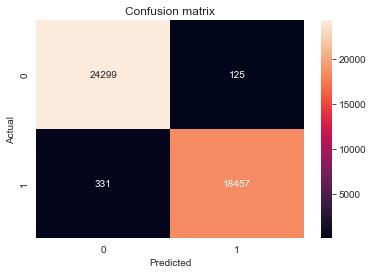

________________________________________________________________________________
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     24424
         1.0       0.99      0.98      0.99     18788

    accuracy                           0.99     43212
   macro avg       0.99      0.99      0.99     43212
weighted avg       0.99      0.99      0.99     43212

Information:
Precision: Percentage of correct positive predictions relative to total positive predictions
Recall: Percentage of correct positive predictions relative to total actual positives.
F1 Score: A weighted harmonic mean of precision and recall. The closer to 1, the better the model.
________________________________________________________________________________


In [17]:
# Plot Confusion matrics
cm = confusion_matrix(y_true=y_train, y_pred=y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.title("Confusion matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Plot classification report
print(80 * "_")
print(classification_report(y_true=y_train, y_pred=y_pred))
print("Information:")
print("Precision: Percentage of correct positive predictions relative to total positive predictions")
print("Recall: Percentage of correct positive predictions relative to total actual positives.")
print("F1 Score: A weighted harmonic mean of precision and recall. The closer to 1, the better the model.")
print(80 * "_")

---
# Task 4: Compare different classification models

Comparing
* logistic regression,
* classification tree,
* random forest,
* bagging,
* support vector machine (with two kernel functions),
* and neural network
for default prediction based on the out-of-sample performance measures (at least three different measures).

In [18]:
%%time
models = []

models.append(("LogisticRegression",LogisticRegression(fit_intercept=True, max_iter=5000, solver="saga")))
models.append(("DecisionTree",DecisionTreeClassifier()))
models.append(("RandomForest",RandomForestClassifier()))
models.append(("BaggingCLF",BaggingClassifier()))
models.append(("SVC_rbf",SVC(kernel='rbf')))
models.append(("SVC_linear",SVC(kernel="linear")))
models.append(("NeuronalNetwork", MLPClassifier(alpha=1, max_iter=1000)))

results = []
names = []
for name, model in tqdm(models):
    result = cross_val_score(model, X_train_scaled, y_train,  cv=3)
    names.append(name)
    results.append(result)

for i in range(len(names)):
    print(names[i],results[i].mean())

100%|██████████| 7/7 [03:03<00:00, 26.28s/it]

LogisticRegression 0.9881514394149772
DecisionTree 0.9887531241321855
RandomForest 0.9936591687494215
BaggingCLF 0.9932194760714617
SVC_rbf 0.9899796352864945
SVC_linear 0.9931037674719985
NeuronalNetwork 0.9763723039896325
CPU times: user 2min 49s, sys: 7.71 s, total: 2min 57s
Wall time: 3min 4s


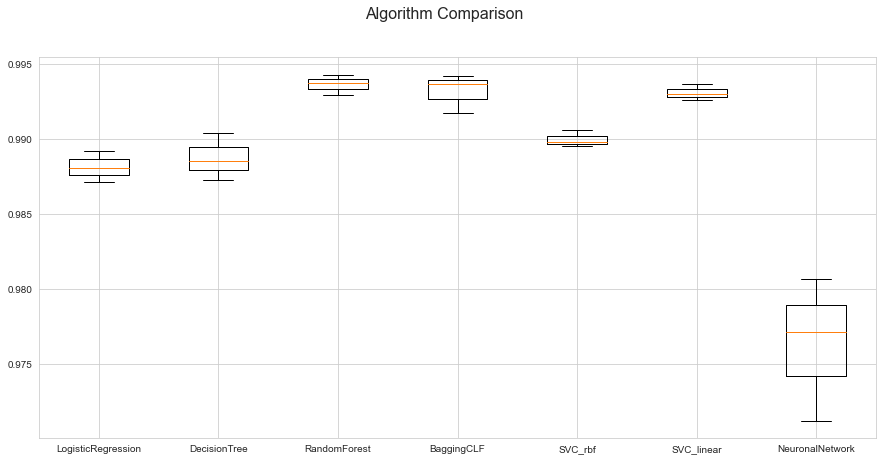

In [19]:
# Boxplot algorithm comparison
fig = plt.figure(figsize=(15,7))
fig.suptitle('Algorithm Comparison', size=16)
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()